# Diver Object

Se me ocurrió que era una idea buenísima hacer un objeto apra el acceso a los datos, 
así no hay que ocuparse de la base de datos a la hora de analizarlos. 

Voy a implementar el objeto _Diver_ que conecta con un _FileID_ y que solicita la data 
en bloques independientes. Las operaciones van a ser _lazy_, es decir que no serán cargados los datos en memoria 
a menos que sea requerido algún dato de ese bloque. 

Veremos cómo nos va. 

In [1]:
%pylab inline
import mysql.connector
from mysql.connector import Error
import xml.etree.ElementTree as ET
from xml.dom import minidom

def dist(r1,r2):
    '''Distancia entre dos puntos
    '''
    x1,y1 = r1
    x2,y2 = r2
    return sqrt((x2-x1)**2+(y2-y1)**2)

class MySQL:
    Host = 'localhost'
    DB   = 'gsr0'
    User = 'willy'
    Pass = 'zapandanga'
    verb = False
    
    ####################################################################
    def __init__(self):
        '''Open connection and cursor
        '''
        self.Connection = None
        self.Cursor     = None
        self.open()
        
    def open(self):
        '''Definida aparte para usar con with...
        '''
        try:
            self.Connection = mysql.connector.connect(host    =self.Host,
                                                      database=self.DB,
                                                      user    =self.User,
                                                      password=self.Pass)
            self.Cursor = self.Connection.cursor()
            if self.verb:
                print("Database {} connected".format(self.DB))

        except  Error as e:
            print ("Error while connecting to MySQL", e)
            
    def close(self):
        '''Esta función cierra la conexón.
        '''
        if(self.Connection.is_connected()):
            self.Cursor.close()
            self.Connection.close()
            if self.verb:
                print("MySQL connection is closed")
        else:
                print("MySQL connection already closed")
                
    ####################################################################
    def query(self,*QQ):
        '''Query
           Tiene tres modos de funcionamiento:
           * una entrada     (Q)      : query (Q)
           * dos entradas    (Q,W)    : query (Q WHERE W)
           * tres entradas   (Q,T,W)  : query (Q FROM T WHERE W)
           * cuatro entradas (Q,T,W,G): query (Q FROM T WHERE W GROUP BY G)
           Si se omite el SELECT, lo agrega.
           
           La salida elimina la lista su hay un sólo resultado.
           Elimina las listas de tuplas de sólo un elemento.
        '''
        if len(QQ)==4:
            Q,T,W,G = QQ
            Q = f'{Q.strip()} FROM {T.strip()} WHERE ({W.strip()}) GROUP BY {G.strip()};'
        elif len(QQ)==3:
            Q,T,W = QQ
            Q = f'{Q.strip()} FROM {T.strip()} WHERE ({W.strip()});'
        elif len(QQ)==2:
            Q,W = QQ
            Q = f'{Q.strip()} WHERE ({W.strip()});'
        elif len(QQ)>4:
            raise Exception('Error in query: 3 arguments or less expected.')
        else:
            Q = QQ[0]
        
        if (not Q.lower().startswith('select')) and \
           (not Q.lower().startswith('show')):    
            Q = 'SELECT ' + Q.strip()
            
           
        self.Cursor.execute(Q)
        R = self.Cursor.fetchall()
        if R==[]:
            return None
        if len(R[0])==1:
            R = list(map(lambda x: x[0],R))
        if len(R)==1:
            R=R[0]
        
        return R        
        
    def columns(self, table):
        '''columns
           Da una lista de los nombres de las columnas de la tabla 'table'
        '''
        cols = self.query(f'SHOW COLUMNS FROM {table}')
        return list(map(lambda x:x[0],cols))

    
class Xml:
    '''et
       ElementTree parser de xml
       xmlStr: string en formato texto xml. 
       devuelve un objeto ElementTree
       Ejemplo: xml
           <main Shape=0>
               <d0 x=1, y=2 />
               <d1 x=3, y=5 />
           </main>
           --------------------------
           out.tag    : 'main' 
           out.attrib : {'Shape':0}
           out[i]     : Element di
    '''
    def __init__(self,xmlStr):
        self.e   = ET.fromstring(xmlStr)
        self.str = xmlStr
        return
    
    def ps(self):
        '''Preety String from xml
           Devuelve un string identado muy bonito
        '''
        rootstr = minidom.parseString(self.str).toprettyxml(indent="  ")
        rootstr = rootstr[rootstr.find('\n')+1:]
        return rootstr

Populating the interactive namespace from numpy and matplotlib


In [2]:
class Diver:
    ####################################################################
    ############################## Carga e inicialización
    def __init__(self, FileID):
        ## Inicializa el acceso a la Base de datos
        self.open()
        
        ## Datos de la tabla File
        Q = 'FileID, Path, Extra, Date, Valid, AreaID'
        R=self.DB.query(Q,'Files', f'FileID={FileID}')
        self.FileID = R[0]
        self.ID = self.FileID
        self.Path   = R[1]
        self.Extra  = R[2]
        self.Date   = R[3]
        self.Valid  = R[4]
        self.AreaID = R[5]
        
        ## Carga Areas
        self.loadAreas()
        ## Carga Features
        self.loadFeatures()
        ## Carga Results
        self.loadResults()
        ## Chau
        self.close()
        
    def open(self):
        '''Abre el acceso a la base de datos.
           Hace falta para reabrir la conexión
        '''
        self.DB=MySQL()    
        
    def close(self):
        '''Cierra el acceso a la base de datos.
           No altera los objetos cargados en memoria pero se pierde la conectividad.
        '''
        self.DB.close()
        
    ####################################################################
    ############################## Loaders
    def loadAreas(self):
        ### Cargo todo
        Areas = []
        for row in self.DB.query('* FROM Areas',f'FileID={self.FileID}'):
            Areas.append(Area(row))
        
        ### Número de Fields
        Q = 'AreaID, count(*)'
        F = 'Fields'
        W = f'FileID={self.FileID}'
        G = 'AreaID'
        fdata = self.DB.query(Q,F,W,G)
        
        if fdata is not None:
            if isinstance(fdata, tuple):
                fdata = [fdata]
            aID,Fields = zip(*fdata)
        else: 
            aID,Fields = [],[]
        ### Clasifico Áreas
        self.Area0        = None
        self.Areas_Checks = []
        self.Areas_Meas   = []
        self.Areas_Xtras  = []
        if self.Valid==1:
            self.Area0        = list(filter(lambda a: a.ID==self.AreaID, Areas))[0]
            self.Area0.Fields = Fields[aID.index(self.AreaID)]
            Areas.remove(self.Area0)
            self.Areas_Meas = list(filter(lambda a: a.ID in aID, Areas))
            for item in self.Areas_Meas:
                item.Fields = Fields[aID.index(item.ID)]
            
        self.Areas_Xtras = list(filter(lambda a: a not in self.Areas_Meas,Areas))
        
        #   Falta separar Areas_Meas de Areas_Checks
        if self.Valid==1:
            Change=True
            while Change:
                Change=False
                parents = [self.Area0.ID]
                for a in self.Areas_Meas:
                    if a.ParentAreaID in parents:
                        Change=True
                        self.Areas_Checks.append(a)
                        parents.append(a.ID)
                self.Areas_Meas = list(filter(lambda a: a not in self.Areas_Checks, self.Areas_Meas))       
                
        ### AreaVariables  (sólo para Area0)
        if self.Valid==1:
            Q = 'Name, Definition'
            T = 'AreaVariables'
            W =f'FileID={self.FileID} AND AreaID={self.Area0.ID} '
            W+= "AND Name IN ('FieldWidth', 'FieldHeight', 'FieldWidthPx', 'FieldHeightPx')"
            Name,Def = list(zip(*self.DB.query(Q,T,W)))
            self.Area0.FieldWidth    = float(Def[Name.index('FieldWidth'   )])
            self.Area0.FieldHeight   = float(Def[Name.index('FieldHeight'  )])
            self.Area0.FieldWidthPx  =   int(Def[Name.index('FieldWidthPx' )])
            self.Area0.FieldHeightPx =   int(Def[Name.index('FieldHeightPx')])
            self.Area0.PixelSize     = self.Area0.FieldWidth / self.Area0.FieldWidthPx
            
            ## Fields Collected
            Q = 'count(*)'
            F = 'Fields'
            W = f'FileID={self.FileID} AND AreaID={self.AreaID} AND DataCollected=1'
            self.Area0.FieldsCollected = self.DB.query(Q,F,W)

        ### Calculo superficies
        self.supCalculator()
        
    def supCalculator(self):
        '''Calcula las áreas y define el límite de la medición
           Tarda tan poco, que lo cargo siempre
        '''
        ### Variables a calcular
        self.FieldPositions = None
        sup = {'All'      : None,
               'Fields'   : None,
               'Collected': None,
               'Polygon'  : None,
              }
        
        if self.Valid==0:
            return
        
        ### Superficies
        sup['All'] = pi * (self.Area0.R)**2
        oneField = self.Area0.FieldWidth * self.Area0.FieldHeight
        sup['Fields'] = self.Area0.Fields * oneField
        sup['Collected'] = self.Area0.FieldsCollected * oneField
        
        ### Limit Polygon
        if self.Area0.FieldsCollected == 0:
            self.Area0.sup = sup
            return
        
        #   Fields
        Q = 'FieldID,X,Y FROM Fields'
        W =f'FileID={self.FileID} AND AreaID={self.AreaID} AND DataCollected=1'
        Fpos = self.DB.query(Q,W)
        if isinstance(Fpos, tuple):
            Fpos = [Fpos]
        Fpos = sorted(Fpos, key=lambda x: x[0])
        self.FieldPositions = Fpos
        _, X,Y = zip(*Fpos)
            
        #   Cuantifico alturas y busco extremos         
        W = self.Area0.FieldWidth
        H = self.Area0.FieldHeight

        y = list(map(lambda x: int(round(x)),(array(Y)-Y[0])/H))
        l = sorted(list(set(y)))                            # levels
        il = [y.index(li)                for li in l      ] # index left
        ir = [len(y)-1-y[::-1].index(li) for li in l[::-1]] # index right
        
        #   Polígono
        Poly = []
        for i in il:
            Poly.append([X[i]-W/2,Y[i]-H/2])
            Poly.append([X[i]-W/2,Y[i]+H/2])
        for i in ir:
            Poly.append([X[i]+W/2,Y[i]+H/2])
            Poly.append([X[i]+W/2,Y[i]-H/2])
        Poly.append(Poly[0])    
        sup['Polygon'] = Poly    
            
        self.Area0.sup = sup
        
    def loadFeatures(self):
        '''Carga las Features
        '''
        # Datos a cargar
        self.FeaturesN = None
        self.Features  = None
        
        ### Cargo todo
        Features = []
        
        ### Lista de Fields que interesan
        FieldPos = self.FieldPositions 
        #   Construyo FS: un string con la lista de Fields
        Fields   = list(map(lambda x: "'" + str(x[0]) + "'", FieldPos)) 
        FS = "("
        for item in Fields:
            FS+= item +", "
        FS = FS[:-2]+")"
        
        ### Lista de Features
        Q = 'FeatureID,FieldID,BB_Top,BB_Left,BB_Height,BB_Width'
        F = 'Features'
        W =f'FileID={self.FileID} '
        W+=f'AND FieldID IN {FS}'
        Feats = self.DB.query(Q,F,W)
        if Feats!=[]:
            if isinstance(Feats, tuple):
                Feats = [Feats]
            Feats = sorted(Feats, key=lambda x: x[0])
        self.FeaturesN = len(Feats)
        
        #   Construyo FeaS: un string con la lista de Features
        Featus   = list(map(lambda x: "'" + str(x[0]) + "'", Feats)) 
        FeaS = "("
        for item in Featus:
            FeaS+= item +", "
        FeaS = FeaS[:-2]+")"

        #   Tabla de Ranks
        Q = 'Rank,Name'
        RankTable = self.DB.query( Q + ' FROM Ranks')
        RName = dict(RankTable)   # RName[RankID]
        
        #   Tabla de Clases
        Q = 'ClassID,Name,Rank,UseForClassification'
        Class_Defs = self.DB.query( Q + ' FROM Classes')
        CDefs = {}
        for ClassID,Name,Rank,UseForClassification in Class_Defs:
            CDefs[ClassID] = { 'ClassID':ClassID,
                               'Name':Name,
                               'Rank':Rank,
                               'RankName':RName[Rank],
                               'UseForClassification':int(UseForClassification)
                             }
        
        #   Asignación de ClassID
        Q = 'FeatureID, ClassID'
        F = 'feature_classifications'
        W =f'FileID={self.FileID} AND FeatureID IN {FeaS}'
        ClassTable = self.DB.query(Q,F,W)
        ClassID = dict(ClassTable)         # ClassID[FeatureID]
        
        for row in Feats:
            F = Feature(row)
            # filto por el FieldID
            FP = list(filter(lambda x: x[0]==row[1] ,FieldPos))[0]
            F.FieldX = FP[1]
            F.FieldY = FP[2]
            F.Class  = CDefs[ClassID[F.ID]]
    
            Features.append(F)
        self.Features = Features

    def loadResults(self):
        '''Carga Results como un diccionario de cada Feature
        '''
        if self.Features is None:
            return
        
        ### Index of FeatureID and void dict Measurements
        iFeature={}     # iFeature[FeatureID] = index of Features
        FeatureS = '('  # String con lista de Features
        for i,item in enumerate(self.Features):
            item.Measurements = {}
            iFeature[item.ID]=i
            FeatureS += f"'{item.ID}', "
        FeatureS = FeatureS[:-2] + ')'
            
        ### Tabla uMeasurements:  Meas[MeasurementID] = {col: val}
        Meas = {}
        Q = 'uMeasurementID, Type, Definition, Units, Name'
        R = self.DB.query(Q+' FROM uMeasurements')
        for uMeasurementID, Type, Definition, Units, Name in R:
            Meas[uMeasurementID]={'Type': Type, 
                                  'Definition': Definition, 
                                  'Units': Units, 
                                  'Name': Name,
                                 }
            
        ### Cargo todos los uResults
        print('Loading Results...', end='')
        Q = 'FeatureID, uMeasurementID, Value, Error FROM uResults'
        W =f"FileID={self.FileID} AND FeatureID IN {FeatureS}"
        R = self.DB.query(Q,W)
        print('  done.-')
        for FeatureID, uMeasurementID, Value, Error in R:
            M = Meas[uMeasurementID]
            self.Features[iFeature[FeatureID]].Measurements[M['Definition']] = {
                'ID'   :uMeasurementID,
                'Type' :M['Type'],
                'Name' :M['Name'],
                'Value':Value,
                'Error':Error,
                'Units':M['Units'],
            }

In [3]:
class Area:
    def __init__(self,row):
        self.AreaID = row[0]
        self.ID = self.AreaID
        self.Name   = row[2]
        self.DataCollected = int(row[4])
        self.Fields = 0
        
        ### Definition is XML
        Definition = Xml(row[3])
        self.Shape = int(Definition.e.attrib['Shape'])
        self.Type  = int(Definition.e.attrib['Type'])
        self.ParentAreaID = int(Definition.e.attrib['ParentAreaID'])
        self.OriginalFeatureID = int(Definition.e.attrib['OriginalFeatureID'])
        
        ### Positions
        R = []
        for p in Definition.e[0]:
            R.append([float(p.attrib['X']),float(p.attrib['Y']),float(p.attrib['Z'])])
        if self.Shape == 0:
            ## Punto
            self.X,self.Y,self.Z = R[0]
        else:
            ## Círculo
            self.X,self.Y,self.Z = R[3]
            X0,Y0,Z0 = R[0]
            self.R = dist([self.X,self.Y],[X0,Y0])

class Feature:
    def __init__(self,row):
        # FeatureID,FieldID,BB_Top,BB_Left,BB_Height,BB_Width
        self.FeatureID = row[0]
        self.ID        = self.FeatureID
        self.BB_Top    = row[2]
        self.BB_Left   = row[3]
        self.BB_Height = row[4]
        self.BB_Width  = row[5]
        self.Class     = None
        self.FieldX    = None
        self.FieldY    = None

## Reparación de _Classes_

Aparecen errores en fID = 58, 285 (sólo miré entre 1 y 300)
Donde dice que ClassID no está definido. 

Cargué la vieja clase en otra base de datos, y el problema es que por algún motivo que no entiendo, 
las definiciones de clases se repiten con otro ID, que no preservé en la tabla Classes final. 

Hay dos maneras de arreglar esto:

### 1. Desde el programa de lectura

Basta notar que los ClassID se repiten, pero siguiendo un patrón:
> 32 -> 1  (-31)  
> 33 -> 2  (-31)  
> ...  
> 38 -> 7  (-31)  
> ...  
> 62 -> 31 (-31)  
> ...  
> 68 -> 37 (-31)  

__Conclusión:__ 
```python
if ClassID > 31: ClassID -= 31
if ClassID < 7 : ClassID += 31
```
_Lo hice, lo probé y anda bien. En este momento está comentado porque es más correcta la segunda solución._

_Se puede descomentar y usar, pero no voy a mantener la compatibilidad en futuras versiones_

### 2. Extender la Tabla Classes

Cuando hice el resumen de la tabla _Classes_ (en el notebook DiverWork) lo hice mal. 

La secuencia correcta sobre la base de datos original es (comandos mySQL):
```mysql
CREATE TABLE Classes2 (`ClassID` int, `Name` varchar (100) NOT NULL, `Rank` int NOT NULL, `UseForClassification` char NOT NULL) SELECT DISTINCT ClassID,Name,Rank,UseForClassification FROM Classes;
DROP TABLE Classes;
RENAME TABLE Classes2 TO Classes;
```

Pero esto no sirve sobre la base de datos ya procesada. Por eso, di un paso atrás y exporté la nueva tabla de clases al archivo `classes.sql`

Se puede importar con:
```
$ mysql -uwilly gsr0 < classes.sql
mysql> DROP TABLE Classes;
mysql> RENAME TABLE Classes2 TO Classes;
```

y queda oK. Chequeado.

El warning es no utilizar nunca el ClassID para nada porque está repetido para el mismo uso.   
En próximas versiones, voy a eliminar ClassID del diccionario de clases. 

In [1]:
%pylab inline
from Diver import Diver
O=Diver(200,loadResults=False)

Populating the interactive namespace from numpy and matplotlib


In [2]:
for i in [58,59,285]:
    print(i,end='++')
    print('**',i,Diver(i,loadResults=False).Valid)

58++** 58 1
59++** 59 1
285++** 285 1


In [2]:
from Diver import MySQL
db = MySQL()
notV = db.query('FileID FROM Files','Valid=0')
print(notV)

[3, 4, 8, 9, 37, 38, 43, 44, 52, 81, 82, 85, 86, 88, 91, 99, 101, 103, 104, 105, 115, 116, 117, 118, 119, 120, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 142, 143, 144, 147, 148, 149, 150, 163, 221, 282, 298, 414, 415, 420, 421, 422, 423, 436, 437, 445, 446, 447, 448, 449, 470, 471, 472, 473, 476, 477, 479, 480, 481, 496, 510, 562, 563, 564, 565, 566, 567, 568, 569, 570, 601, 806, 807]


58  loadFeatures key error 375 (valid)


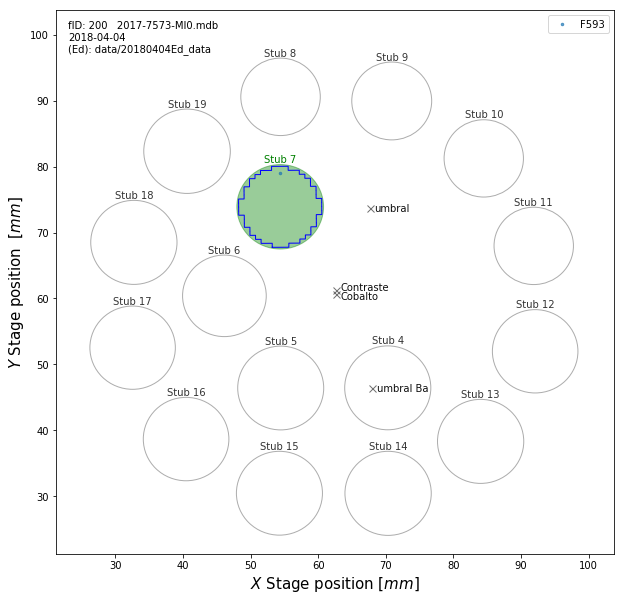

In [28]:
def reportFile(O):
    oP = '/'.join(O.Path.split('/')[1:-1])
    oF = O.Path.split('/')[-1]
    ou = f'fID: {O.FileID}   {oF}\n{O.Date}\n({O.Extra}): {oP}'
    if O.Valid==0:
        ou+='\nNot Valid'
    return ou

def pLimits(xmin,xmax,ymin,ymax):
    plot([xmin,xmax],[ymin,ymax],'w.')
        
def printReportFile(x,y,O,**kwargs):
    text(x,y,reportFile(O),
         verticalalignment='top',
         horizontalalignment='left',
         **kwargs)
        
def PlotArea(Area,marker='x'):
    try:
        Area0 = True
        col='g'
        poly  = Area.sup['Polygon']
        fill  = True
    except:
        Area0 = False
        col='#333333'
        poly  = None
        fill = False
        if marker=='.': markerS = 5
        else          : markerS = 7
    
    if Area.Shape == 3:
        X,Y,R = Area.X,Area.Y,Area.R
        circle1 = Circle([X,Y], R, color=col,Fill=fill, alpha=.4)
        gca().add_artist(circle1)
        text(X,Y+R,Area.Name, va='bottom', ha='center', color=col)
    else:
        X,Y = Area.X,Area.Y
        shiftX = 0.7
        shiftY = 0
        if Area.Name=='Contraste': shiftY= 0.9
        if Area.Name=='Cobalto'  : shiftY=-0.9

        keys={'marker'    :marker, 
              'markersize':markerS,
              'alpha'     :.7}
        
        if marker!='.':
            keys['color']=col
            text(X+shiftX,Y+shiftY,Area.Name,va='center',ha='left',alpha=0.95)
        else:
            keys['label']=Area.Name[Area.Name.find('(')+1:-1]
            
        plot(X,Y,'o', **keys)
        
    if Area0:
        plot(*zip(*poly),'b-',lw=1)
        
def plotAreas(O):
    for Area in O.Areas_Xtras:
        PlotArea(Area)
    for Area in O.Areas_Meas:
        PlotArea(Area,marker='o')
    for Area in O.Areas_Checks:
        PlotArea(Area,marker='.')
        
    if O.Valid==1:
        PlotArea(O.Area0)
    
        
figure(figsize=(10,10))
pLimits(25,100,25,100)
plotAreas(O)
printReportAreas(23,102,O)
xlabel(r'$X$ Stage position $[mm]$',fontsize=15)
ylabel(r'$Y$ Stage position  $[mm]$',fontsize=15)
legend(loc=1)

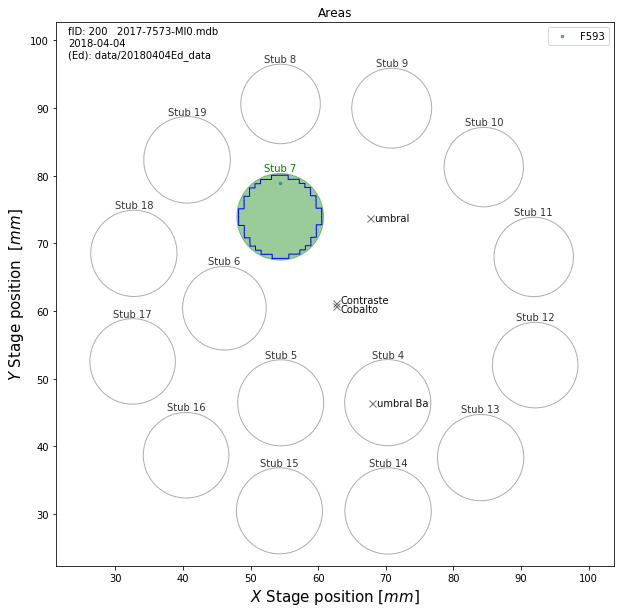

In [2]:
figure(figsize=(10,10))
O.plotAreas()


# 2Do
* Report
* plots
* posición de Features
* 

## class Diver

|  props        |  def                        |  type             |
|---------------|-----------------------------|-------------------|
| .FileID = .ID | ID del constructor          | _int_             |  
| .Path         | .mdb original               | _str_             |
| .Extra        | (op) data del path          | _str_             |
| .Date         | fecha del path              | _date_            |
| .Valid        | tiene fields con mediciones | _int_             |
| .             | .                           | .                 |
| .AreaID       | ID del área principal       | _int_             |  
| .Area0        | área principal              |  _class Area_     |
| .Areas_Checks | chequeos del área principal | _[class Area]_    |
| .Areas_Meas   | otras áreas medidas         | _[class Area]_    |
| .Areas_Xtras  | áreas no medidas            | _[class Area]_    |
| .             | .                           | .                 |
| .FeaturesN    | número de features de Area0 | _int_             |
| .Features     | features del área principal | _[class Feature]_ |

|  meths          |  def                        |
|-----------------|-----------------------------|
| Diver(FileID)   | constructor del objeto      |
| .close()        | cierra la base de datos     |
| .loadAreas()    | (auto) carga áreas          |
| .loadFeatures() | (auto) carga features       |

## class Area

|  props             |  def                        |  type             |
|--------------------|-----------------------------|-------------------|
| .AreaID = .ID      | ID del constructor          | _int_             |  
| .Name              | nombre                      | _str_             |
| .DataCollected     | 0/1 si hay medición         | _int_             |
| .Fields            | número de campos diseñados  | _int_             |
| .Shape             | 0:punto / 3:círculo         | _int_             |
| .Type              | ?                           | _int_             |
| .ParentAreaID      | sub área de este ID         | _int_             |
| .OriginalFeatureID | detalle del Feature ID      | _int_             |
| .X .Y .Z / .R      | posición (mm)               | _float_           |
| .                  | .                           | .                 |
| .                  | __sólo en Area0__           | .                 |
| .                  | .                           | .                 |
| .FieldWidth        | ancho del campo (mm)        | _float_           |
| .FieldHeight       | altura del campo (mm)       | _float_           |
| .FieldWidthPx      | ancho del campo (píxeles)   | _int_             |
| .FieldHeightPx     | altura del campo (píxeles)  | _int_             |
| .PixelSize         | tamaño del píxel (mm)       | _float_           |
| .FieldsCollected   | número de campos medidos    | _int_             |
| .sup               | estadística de superficies  | _dict_            |
| .sup['All']        | - del Stub                  | _float_           |
| .sup['Fields']     | - de todos los campos       | _float_           |
| .sup['Collected']  | - de los campos medidos     | _float_           |
| .sup['Polygon']    | - polígono de medición      | _[[x,y],... ]_    |

## class Feature

|  props                   |  def                        |  type             |
|--------------------------|-----------------------------|-------------------|
| .FeatureID = .ID         | ID del constructor          | _int_             | 
| .BB_Top/Left/Height/Width| bounding box de imagen (px) | _int_             |
| .FieldX  / .FieldY       | centro del field            | _float_           |
| .Class                   | clasificación               | _dict_            |
| .Class['ClassID']              | ID                    | _int_             |
| .Class['Name']                 | Class Name            | _str_             |
| .Class['Rank']                 | Rank                  | _int_             |
| .Class['RankName']             | Rank Name             | _str_             |
| .Class['UseForClassification'] | ?                     | _int_             |
| .                              | .                     | .                 |
| .                              | __loadResults__       | .                 |
| .                              | .                     | .                 |
| .Measurements                  | resultados de mediciones |  _dict_        |
| .Measurements[Definition]      | resultado de una medición|  _dict_        |
| .Measurements[Definition] ['ID']    | resultado de una medición|  _int_    |
| .Measurements[Definition] ['Type']  | resultado de una medición|  _int_    |
| .Measurements[Definition] ['Name']  | resultado de una medición|  _str_    |
| .Measurements[Definition] ['Value'] | resultado de una medición|  _float_  |
| .Measurements[Definition] ['Error'] | resultado de una medición|  _float_  |
| .Measurements[Definition] ['Units'] | resultado de una medición|  _str_    |

_Definition_ in  
> Area,  
> AspectRatio,  
> Breadth,  
> CentreX, CentreY,  
> Direction,  
> ECD,  
> Length,  
> Perimeter,  
> Shape,  
> X, Y, Z,  
> CameoX, CameoY,  
> MeanGrey,  
> SpectrumArea,  
> AC% z, Wt% z  
